In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold,GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import warnings
import random
import matplotlib.pyplot as plt


## Some utility functions to print out reports 

In [3]:
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

def print_regression_report(y_val, y_pred, fold):
    print(f'Fold: {fold}')
    print('Mean absolute error:', mean_absolute_error(y_val, y_pred))
    print('Mean squared error:', mean_squared_error(y_val, y_pred))
    print('Root Mean squared error:', np.sqrt(mean_squared_error(y_val, y_pred)))

def print_classification_report(y_val, y_pred, fold):
    print(f'Fold: {fold}')
    print(f'Accuracy Score: {accuracy_score(y_val, y_pred)}')
    print(f'Confusion Matrix: \n {confusion_matrix(y_val, y_pred)}')
    print(f'Classification Report: \n {classification_report(y_val, y_pred)}')

def print_multilabel_classification_report(y_val, y_pred, fold):
    print(f'Fold: {fold}')
    print(f'Accuracy Score: {accuracy_score(y_val, y_pred)}')
    print(f'Confusion Matrix: \n {confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))}')
    print(f'Classification Report: \n {classification_report(y_val, y_pred)}')



## Data Preview

   rating                                              title  \
0       2                                           Great CD   
1       2  One of the best game music soundtracks - for a...   
2       1                   Batteries died within a year ...   
3       2              works fine, but Maha Energy is better   
4       2                       Great for the non-audiophile   

                                              review  
0  My lovely Pat has one of the GREAT voices of h...  
1  Despite the fact that I have only played a sma...  
2  I bought this charger in Jul 2003 and it worke...  
3  Check out Maha Energy's website. Their Powerex...  
4  Reviewed quite a bit of the combo players and ...  
2    200000
1    200000
Name: rating, dtype: int64


<AxesSubplot:>

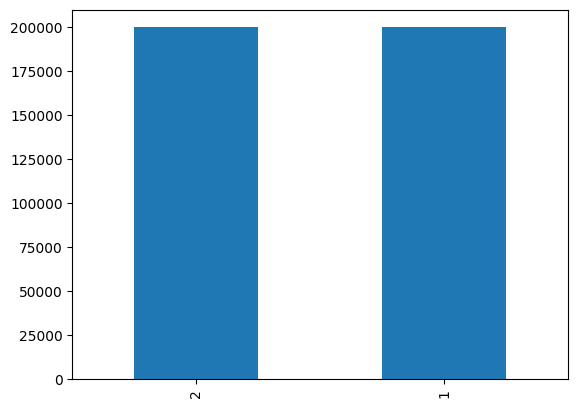

In [4]:
# data set preview
data = pd.read_csv('datasets/mcdonald_reviews/amazon_test.csv', encoding='latin-1', header=None)
data.columns = ['rating', 'title', 'review']
print(data.head(5))

print(data['rating'].value_counts())
data['rating'].value_counts().plot(kind='bar')

In [ ]:
label_encoder = LabelEncoder()

def read_data(file_path):
    data = pd.read_csv(file_path, encoding='latin-1', header=None)
    data.columns = ['rating', 'title', 'review']
    data.dropna(inplace=True)
    
    X, y = data['title'].values + data['review'].values, data['rating'].values
    y = label_encoder.fit_transform(y)

    return X, y, data


X, y, data = read_data('datasets/mcdonald_reviews/amazon_test.csv')
print(f'size of data: {len(data)}, shape of X: {X.shape}, shape of y: {y.shape}')

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
fold = 1

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3), lowercase=True)
    vectorizer.fit(X_train)

    X_train = vectorizer.transform(X_train)
    X_val = vectorizer.transform(X_val)

    model = XGBClassifier(n_estimators=700, learning_rate=0.2, max_depth=5, colsample_bytree=0.3, n_jobs=-1, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    print_classification_report(y_val, y_pred, fold)
    fold += 1

    misclassified = np.where(y_val != y_pred)
    misclassified_labels = y_val[misclassified]
    misclassified_predictions = y_pred[misclassified]
    misclassified_reviews = data['review'].values[misclassified]

    indices = random.sample(range(len(misclassified_labels)), 10)

    for i in indices:
        print(f'Review: {misclassified_reviews[i]}, Actual: {misclassified_labels[i]}, Predicted: {misclassified_predictions[i]}')

In [12]:
label_encoder = LabelEncoder()

def read_data(file_path):
    data = pd.read_csv(file_path, encoding='latin-1', header=None)
    data.columns = ['rating', 'title', 'review']
    data.dropna(inplace=True)
    
    X, y = data['title'].values + data['review'].values, data['rating'].values
    y = label_encoder.fit_transform(y)

    return X, y, data


X, y, data = read_data('datasets/mcdonald_reviews/amazon_test.csv')
print(f'size of data: {len(data)}, shape of X: {X.shape}, shape of y: {y.shape}')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3), lowercase=True)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)

model = XGBClassifier(n_estimators=700, learning_rate=0.2, max_depth=5, colsample_bytree=0.3, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

X_val = vectorizer.transform(X_val)
y_pred = model.predict(X_val)

print_classification_report(y_val, y_pred, 1)

misclassified = np.where(y_val != y_pred)
misclassified_labels = y_val[misclassified]
misclassified_predictions = y_pred[misclassified]
misclassified_reviews = data['review'].values[misclassified]

indices = random.sample(range(len(misclassified_labels)), 10)

for i in indices:
    print(f'Review: {misclassified_reviews[i]}, Actual: {misclassified_labels[i]}, Predicted: {misclassified_predictions[i]}')

size of data: 399990, shape of X: (399990,), shape of y: (399990,)
Fold: 1
Accuracy Score: 0.9004100102502562
Confusion Matrix: 
 [[35824  4101]
 [ 3866 36207]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90     39925
           1       0.90      0.90      0.90     40073

    accuracy                           0.90     79998
   macro avg       0.90      0.90      0.90     79998
weighted avg       0.90      0.90      0.90     79998

Review: I absolutely adore these vitamins. Liked them so much I bought the child version for my son.Since I have been taking them I do not have the urge to drink coffee- of course the down side to that is fighting thru the ensuing withdrawal symptoms. Otherwise I feel great and maintain a steady energy level all day. The taste isn't all that pleasant sometimes but it's mostly a kinda vitaminy aftertaste and is hit or miss. Totally tolerable.I noticed no one mentioned the effect Sour

In [14]:
model.save_model('sentiment_analysis.model')